# Validation of HEALPix Regridding for Sentinel-2 Data Using Spline Representation

## Context and Motivation

When working with satellite data such as **Sentinel-2**, a common representation uses one value per pixel - whether it's sampled at the center or averaged over the pixel area. While this approach is simple, it becomes problematic when the goal is to **preserve fine-scale spatial information**. Achieving this usually requires higher sampling resolution, which leads to significant increases in data volume.

However, real satellite observations are affected by the instrument's **Point Spread Function (PSF)**. This optical smoothing causes the observed signal to be **inherently smooth** at the pixel scale, with **low intra-pixel variability**. The signal is therefore **band-limited**, and its spectral content decays in a way that aligns well with **spline basis functions in Fourier space**.

### Why Use HEALPix Level 19?

This notebook demonstrates that **HEALPix at Level 19**, with a pixel size of ~13.5 m, is sufficient to capture the full information content of Sentinel-2 **10 m** resolution data (specifically Band B02). This is justified by:

- The PSF of Sentinel-2 is significantly larger than a single 10 m pixel.
- Spline interpolation aligns well with the smoothness induced by the PSF.
- The number of pixels in HEALPix Level 19 is **~40% less than UTM**, saving storage.

## Objective of This Notebook

This notebook presents a **validation test** to ensure that regridding onto HEALPix Level 19 preserves spatial information **at least as well as** the current L1C processing chain. The test includes:

1. **Reprojecting L1B reflectance data (Band B02)** to:
   - UTM 10 m grid,
   - HEALPix Level 19 grid using **spline interpolation**,
   - Standard L1C product for comparison.

2. **Interpolating** the regridded data (HEALPix + L1C) back into the original L1B geometry using **bicubic interpolation**.

3. **Comparing power spectra** of the original L1B image and reconstructed images to assess how much spatial information is preserved or lost in each method.

### Key Results

- HEALPix Level 19 with spline interpolation captures high-frequency texture **better than the standard L1C product**.
- The **power spectral comparison** shows excellent agreement between original and HEALPix spline-regridded data.
- Storing spline coefficients instead of raw pixel values:
  - Enables **consistent compression**,
  - Facilitates conversion to classical formats like UTM when needed,
  - Provides an efficient foundation for high-resolution analysis and reconstruction.

## Conclusion

This notebook demonstrates that:
- A **spline-based HEALPix Level 19** grid is a **robust and efficient representation** of Sentinel-2 data.
- It maintains or exceeds the quality of current L1C processing while reducing redundancy and enabling more consistent mathematical operations.

## Authors

- J.-M. Delouis, LOPS, UMR6523 CNRS - IFREMER - IRD - UBO
- T. Odaka, LOPS, UMR6523 CNRS - IFREMER - IRD - UBO

In [1]:
# Import all needed package
# package needed for the HEALPIX spline approach
import foscat.HealSpline as HS
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# package needed for the powerspctra computation
from scipy.fft import fft2, fftshift

# package needed to zoom coordinate (lat,lon) to compute zoom from HEALPIX spline
from scipy.ndimage import zoom

The figure bellow shows the PSF of Sentinel-2 Band B02 overlaid with:
- The UTM 10 m grid (red square),
- The HEALPix Level 19 projection (solid yellow),
- The HEALPix Level 20 projection (dotted yellow).

📌 **Data Source:** [Sentinel-2 PSF – SentiWiki](https://sentiwiki.copernicus.eu/web/s2-mission)

/tmp/ipykernel_1354535/2491367724.py:14: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(psf / (psf > 1E-4))


Text(0.5, 1.0, 'Sentinel-2 B02 PSF')

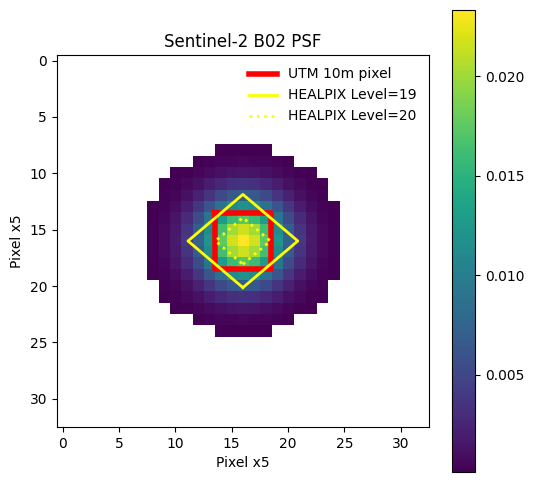

In [2]:
# --- Load and display the Point Spread Function (PSF) for Sentinel-2 band B02 ---

# Load the PSF (Point Spread Function) from a 33x33 NumPy array
psf = np.load("data/S2A_PSF_B02_33x33.npy", allow_pickle=True)

# Set the HEALPix level to compare grid sizes
level = 19

# Create a square plot
plt.figure(figsize=(6, 6))

# Normalize and display the PSF as an image
# (divide by mask to highlight where PSF > threshold)
plt.imshow(psf / (psf > 1e-4))

# Add labels for axis
plt.xlabel("Pixel x5")  # Zoomed pixel grid (for better resolution visualization)
plt.ylabel("Pixel x5")

# Plot a red square indicating a 10 m UTM pixel extent (5x5 pixels in PSF grid)
plt.plot(
    [13.5, 18.5, 18.5, 13.5, 13.5],
    [13.5, 13.5, 18.5, 18.5, 13.5],
    color="r",
    lw=4,
    label="UTM 10m pixel",
)

# --- Plot a yellow contour showing the approximate HEALPix Level=19 cell size ---

# Get the boundaries of a HEALPix cell at Level=19 (using nested indexing)
x, y, z = hp.boundaries(2**level, 6 * 4**level, step=1, nest=False)
x = np.concatenate([y, [y[0]]])  # reassign and close the polygon
x -= x.mean()  # center the footprint
y = np.concatenate([z, [z[0]]])  # reassign and close
plt.plot(
    x * 6500e3 / 2 + 16,
    y * 6500e3 / 2 + 16,
    color="yellow",
    lw=2,
    label="HEALPIX Level=19",
)

# --- Repeat for Level=20 (dashed outline for comparison) ---
x, y, z = hp.boundaries(2 ** (level + 1), 6 * 4 ** (level + 1), step=1, nest=False)
x = np.concatenate([y, [y[0]]])
x -= x.mean()
y = np.concatenate([z, [z[0]]])
plt.plot(
    x * 6500e3 / 2 + 16,
    y * 6500e3 / 2 + 16,
    ":",
    color="yellow",
    lw=2,
    label="HEALPIX Level=20",
)

# Add legend and colorbar
plt.legend(frameon=0)
plt.colorbar()

# Title of the plot
plt.title("Sentinel-2 B02 PSF")

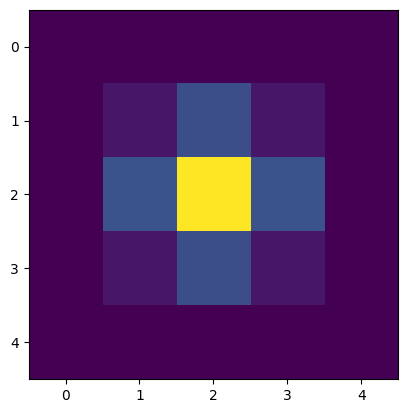

In [3]:
# project the PSF into 10m resolution
kernel = np.zeros([5, 5])
off = 4
for k in range(5):
    for l in range(5):
        kernel[k, l] = np.mean(
            psf[off + 5 * k : off + 5 * (k + 1), off + 5 * l : off + 5 * (l + 1)]
        )
plt.imshow(kernel)

# Read L1C data

In [4]:
# Get the L1C data
import fsspec
import xarray as xr

url = "https://data-taos.ifremer.fr/GRID4EARTH/S2A_MSIL1C_20250724T112131_N0511_R037_T30UUU_20250724T145646.zarr"

ds = xr.open_datatree(url, engine="zarr")  # Use True if you know it's consolidated

This code ensures a complete and precise conversion from UTM to WGS84 for the Sentinel-2 B02 band, allowing further analysis or interpolation in geographic coordinates.

In [5]:
# --- Code Block Start ---
# Extract the B02 band (10m resolution)
b02 = ds.measurements.reflectance.r10m.b02

# Rename dimensions BEFORE assigning new coordinate values
# This ensures that rioxarray correctly identifies spatial dimensions.
b02 = b02.rename({"x_10m": "x", "y_10m": "y"})

# Assign coordinate values to the renamed dimensions
# Here we inject the actual coordinate arrays (in meters, UTM projection) from the dataset.
b02 = b02.assign_coords(
    x=ds.measurements.reflectance.r10m.x.values,
    y=ds.measurements.reflectance.r10m.y.values,
)

# Declare the spatial dimensions for rioxarray
# This step allows rioxarray to interpret 'x' and 'y' as geospatial axes.
b02.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)

# Define the Coordinate Reference System (CRS)
# EPSG:32630 corresponds to UTM zone 30N (used in this Sentinel-2 tile).
b02.rio.write_crs("EPSG:32630", inplace=True)

# Reproject the image to WGS84 (latitude/longitude)
# This changes the grid from projected coordinates (meters) to geographic (degrees).
b02_latlon = b02.rio.reproject("EPSG:4326")

# Extract 1D latitude and longitude coordinate arrays
# These represent the center coordinates of each grid row/column in degrees.
lat = b02_latlon["y"]
lon = b02_latlon["x"]

/tmp/ipykernel_1354535/1573529515.py:7: UserWarning: rename 'x_10m' to 'x' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  b02 = b02.rename({'x_10m': 'x', 'y_10m': 'y'})
/tmp/ipykernel_1354535/1573529515.py:7: UserWarning: rename 'y_10m' to 'y' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  b02 = b02.rename({'x_10m': 'x', 'y_10m': 'y'})


In [6]:
# --- Code Block Start ---
from scipy.interpolate import RegularGridInterpolator

# Extract 1D coordinate arrays
# These are the latitude and longitude values along the grid axes.
# RegularGridInterpolator requires 1D grid axes.
lat_1d = b02_latlon["y"].values
lon_1d = b02_latlon["x"].values

# Extract reflectance data (2D array)
# This is the variable to interpolate, corresponding to each (lat, lon) grid cell.
values = b02_latlon.values

# Create the interpolator object
# This will allow us to interpolate reflectance at any geographic (lat, lon) position.
interp_func = RegularGridInterpolator(
    (lat_1d, lon_1d),  # Grid axes: first latitude (rows), then longitude (columns)
    values,  # Data values to interpolate over
    method="linear",  # Interpolation method: 'nearest', 'linear', or 'cubic'
    bounds_error=False,  # If True: raises an error for points outside the domain
    # If False: assigns fill_value to out-of-bound queries
    fill_value=np.nan,  # Fill value used for points outside the interpolation grid
)

# read the L1B data

In [7]:
# --- Code Block Start ---
ds = xr.open_zarr(
    "https://data-taos.ifremer.fr/GRID4EARTH/S2A_OPER_MSI_L1B_GR_2APS_20250724T145646_S20250724T112804_D06_N05.11_B02.zarr"
)
ds.longitude.values.mean(), ds.latitude.values.mean()

(np.float64(-4.825284320031232), np.float64(48.60969080616767))

## Convert the L1C to L1B coordinate

In [8]:
# Select a subregion of the dataset to evaluate
# We extract a 512×512 pixel window from the lower-right part of the data.
# Specifically, this selects rows -1024 to -512 and columns -512 to the end.
# (Typical for comparing local interpolation accuracy.)

# Flatten the latitude and longitude arrays for this subregion
lat_subset = ds.latitude.values[-1024:-512, -512:]
lon_subset = ds.longitude.values[-1024:-512, -512:]

# Prepare interpolation points
# Combine the lat and lon into a 2D array of shape (N, 2)
# Each row corresponds to a single point: [lat, lon]
interp_points = np.array([lat_subset.flatten(), lon_subset.flatten()]).T

# Perform interpolation using the previously defined function
# This gives us the interpolated B02 reflectance values for this region
utm = interp_func(interp_points).reshape(512, 512)

## Extract 512×512 data from the whole L1B dataset

In [9]:
# 1️⃣ Extract a 512×512 window from the lower-right corner of the data arrays
# These slices select:
# - Rows from -1024 to -512 (i.e., a band near the bottom)
# - Columns from -512 to the end (i.e., rightmost region)

# 2️⃣ Longitude: add 360 to convert from [-180, +180] to [0, 360] format (optional, depending on convention)
lon = 360 + ds.longitude.values[-1024:-512, -512:]

# 3️⃣ Latitude: just extract the values in degrees north
lat = ds.latitude.values[-1024:-512, -512:]

# 4️⃣ Reflectance data: B02 band (10m resolution) from the same 512×512 region
data = ds.B02.values[-1024:-512, -512:]

In [10]:
# Compute the kernel to make the PSF FFT later on

# 1️⃣ Initialize a 2D array of zeros with the same shape as `data`
# This will be used to place the PSF (Point Spread Function) kernel in the center of a larger image.
res2 = 0 * data

# 2️⃣ Insert the kernel into the center region of the array
# Specifically, place the 5×5 `kernel` starting at position (256, 256)
# This centers the kernel inside a typically larger array (e.g., 512×512) before applying the FFT.
res2[256 : 256 + 5, 256 : 256 + 5] = kernel

## Compute the co-latitude and longitude for HEALPix standard functions

In [11]:
# 1️⃣ Convert latitude to co-latitude (θ)
# HEALPix expects input in spherical coordinates:
# - θ (theta) is the co-latitude = 90° - latitude
# - Convert degrees to radians using np.deg2rad
t = np.deg2rad(90.0 - lat).flatten()

# 2️⃣ Convert longitude to radians
# This is the azimuthal angle φ (phi) in spherical coordinates
p = np.deg2rad(lon).flatten()

# 3️⃣ Flatten the data array (reflectance or any signal)
# This prepares the signal `sim` to match the 1D shape of t and p
sim = data.flatten()

## Compute the binned HEALPix data (i.e., regrid the image into HEALPix)

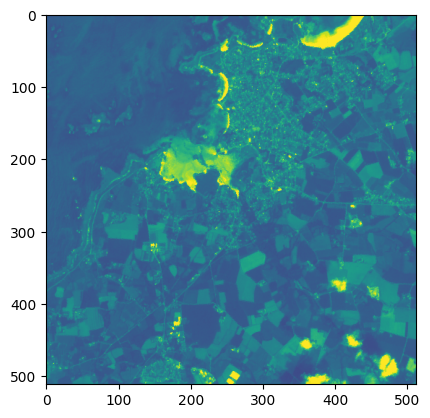

In [12]:
# 1️⃣ Define the HEALPix resolution level
# Level 19 corresponds to ~14m resolution pixels
level = 19

# 2️⃣ Convert spherical coordinates (θ, φ) to HEALPix pixel indices
# This maps each point to a HEALPix pixel (NESTED ordering)
hidx = hp.ang2pix(2**level, t, p, nest=True)

# 3️⃣ Get the unique pixel IDs and an index array to map back later
# - h: unique HEALPix pixel IDs
# - ih: for each input point, the index of its pixel in h
h, ih = np.unique(hidx, return_inverse=True)

# 4️⃣ Count how many points fall in each HEALPix bin
hres = np.bincount(ih)

# 5️⃣ Compute the total signal per pixel (sum of values in each bin)
res3 = np.bincount(ih, weights=sim)

# 6️⃣ Normalize the result: average value per pixel
res3 = (res3 / hres)[ih].reshape(data.shape[0], data.shape[1])

# 7️⃣ Optional scatter plot to visualize the values
# (commented out for now)
# plt.scatter(lon, lat, c=np.tanh((res3 - np.median(res3)) / np.std(res3)), s=1)

# 8️⃣ Display the image using a fixed value range
# This helps visualize dynamic range consistently
plt.imshow(res3, vmin=200, vmax=500)

# Compute the HEALPix spline interpolation of the image

In [13]:
# 1️⃣ Create a spline basis object on the HEALPix grid
# - `level` defines the HEALPix resolution (e.g., 2^19 pixels)
# - `gamma` is a regularization parameter (controls smoothness)
sp = HS.heal_spline(level, gamma=1.5)

# 2️⃣ Fit the spline model to the signal
# - `sim` is the 1D array of reflectance values
# - `(t, p)` are the spherical coordinates (co-latitude and longitude)
# - `max_iter=400` sets the maximum number of iterations in the optimizer
sp.Fit(sim, t, p, max_iter=400)

# 3️⃣ Evaluate (project) the fitted spline model back onto the input coordinates
# This interpolated result is reshaped into the original 2D image shape
rim = sp.Transform(t, p).reshape(data.shape[0], data.shape[1])

Iter 000: residual = 1.950e+03
Iter 050: residual = 4.632e+01
Iter 100: residual = 3.665e+01
Iter 150: residual = 2.697e+01
Iter 200: residual = 3.729e+01
Iter 250: residual = 3.220e+01
Iter 300: residual = 2.375e+01
Iter 350: residual = 3.284e+01


### This block creates a visual side-by-side comparison:

The original Sentinel-2 L1B data.
A zoomed section for detail inspection.
- The L1B data reconstructed from L1C using bicubic interpolation.
- The L1B data reconstructed from HEALPix Level 19 using spline projection.
This visualization is crucial to highlight the better texture preservation by the HEALPix spline approach compared to the standard L1C transformation.

([], [])

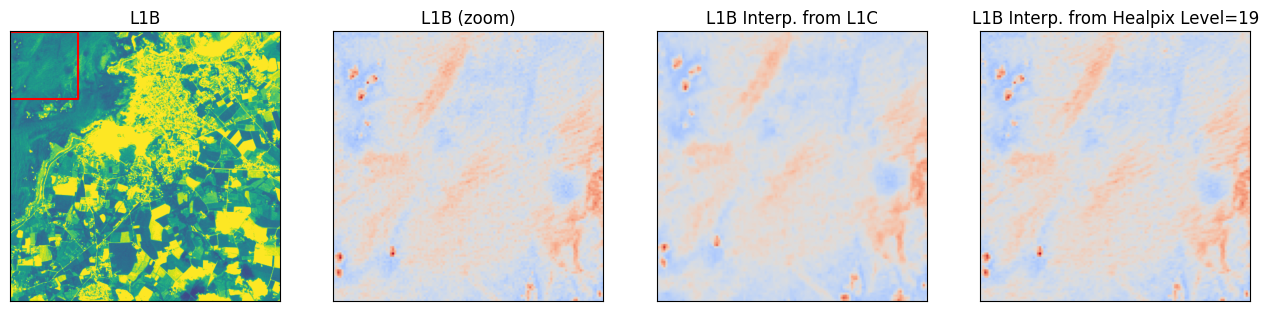

In [14]:
# Plot the comparison results: original L1B, zoomed version, interpolated from L1C, and interpolated from HEALPix

# 1️⃣ Normalize the L1C-based interpolated data (`utm`)
# We apply a linear fit to match the L1B dynamic range (scale + offset)
a = np.polyfit(utm.flatten(), data.flatten(), 1)  # Fit: data ≈ a[0] * utm + a[1]
utm = utm * a[0] + a[1]  # Apply fit to adjust intensity range

# 2️⃣ Set the color map for the plots
cmap = "coolwarm"

# 3️⃣ Create a wide figure with 4 subplots
plt.figure(figsize=(16, 8))

# --- Subplot 1: Full L1B image ---
plt.subplot(1, 4, 1)
plt.title("L1B")  # Title: Original L1B image
plt.imshow(data, vmin=250, vmax=340, cmap="viridis")  # Full L1B data
plt.plot(
    [0, 0, 128, 128, 0], [0, 128, 128, 0, 0], color="r"
)  # Red square to show zoom area
plt.xticks([])
plt.yticks([])

# --- Subplot 2: Zoomed L1B (128x128 area) ---
plt.subplot(1, 4, 2)
plt.title("L1B (zoom)")
plt.imshow(
    data[0:128, 0:128], vmin=250, vmax=340, cmap=cmap
)  # Zoom into top-left 128×128 block
plt.xticks([])
plt.yticks([])

# --- Subplot 3: L1B Interpolated from L1C data ---
plt.subplot(1, 4, 3)
plt.title("L1B Interp. from L1C")
# Adjust contrast slightly by scaling and shifting
plt.imshow(utm[0:128, 0:128] * 1.25 - 80, vmin=250, vmax=340, cmap=cmap)
plt.xticks([])
plt.yticks([])

# --- Subplot 4: L1B Interpolated from HEALPix (Spline) ---
plt.subplot(1, 4, 4)
plt.title("L1B Interp. from Healpix Level=19")
plt.imshow(
    rim[0:128, 0:128], vmin=250, vmax=340, cmap=cmap
)  # Zoomed Healpix spline result
plt.xticks([])
plt.yticks([])

## Compute a zoomed-in version (×5) of a central 128×128 pixel subregion

In [15]:
# --- Define the size of the zoom region (dx = 64 → region = 129×129 pixels) ---
dx = 64


# --- Extract and zoom (×5) the co-latitude (theta) array ---
# t was originally a flattened array → reshape to match image shape
# We crop a square region centered on the image
t2 = zoom(
    t.reshape(data.shape[0], data.shape[1])[
        data.shape[0] // 2 - dx : data.shape[0] // 2 + 1 + dx,
        data.shape[1] // 2 - dx : data.shape[1] // 2 + 1 + dx,
    ],
    zoom=5,  # 5x enlargement
    order=3,  # bicubic interpolation
)

# --- Same operation for longitude (phi) ---
p2 = zoom(
    p.reshape(data.shape[0], data.shape[1])[
        data.shape[0] // 2 - dx : data.shape[0] // 2 + 1 + dx,
        data.shape[1] // 2 - dx : data.shape[1] // 2 + 1 + dx,
    ],
    zoom=5,
    order=3,
)

# --- Apply the spline Healpix projection at higher resolution ---
# We transform the upsampled angular coordinates (t2, p2)
# to get a high-resolution (super-resolved) image using the fitted spline model
rim2 = sp.Transform(t2.flatten(), p2.flatten()).reshape(t2.shape[0], t2.shape[1])

Text(0.5, 1.0, 'B02 Spline Upscale ×5')

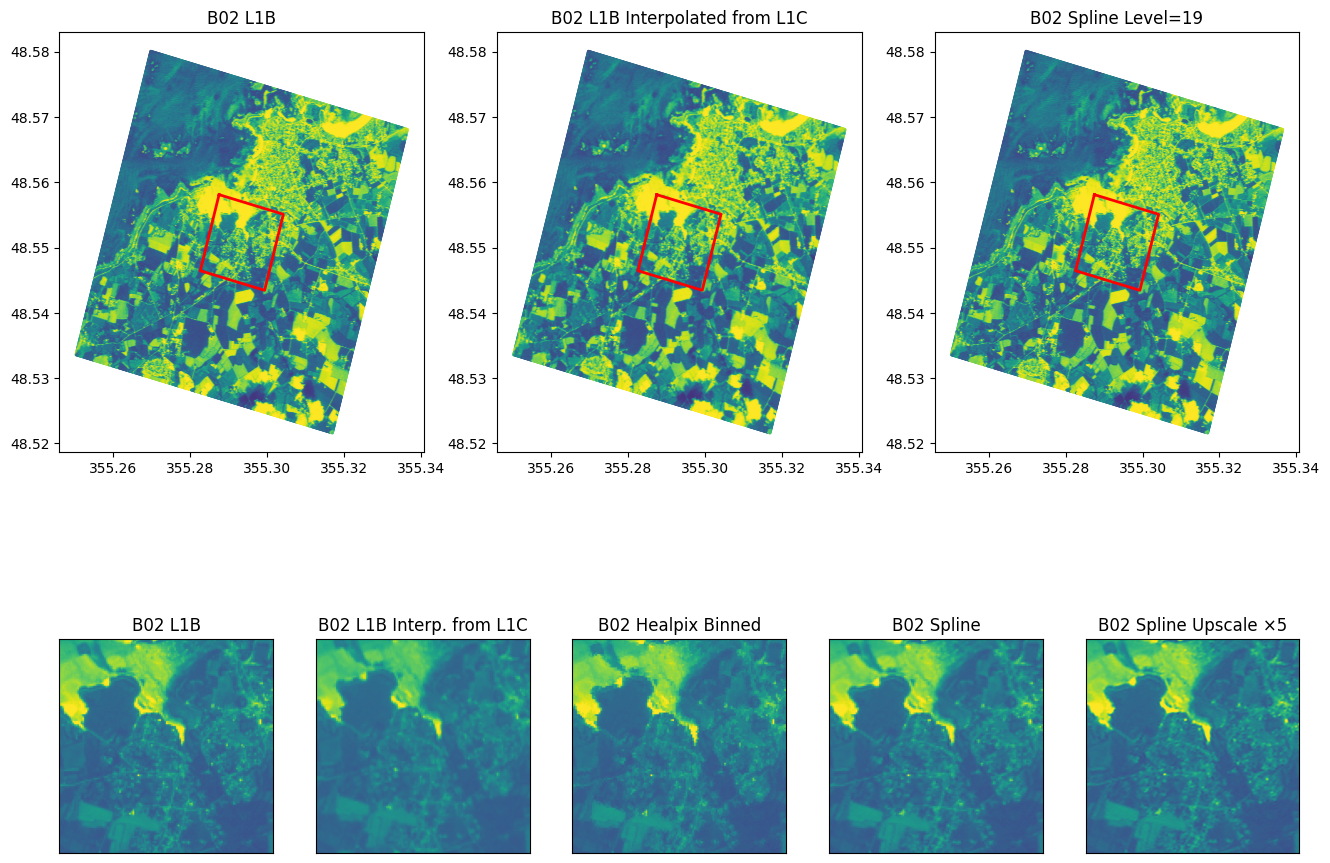

In [16]:
# Create a composite figure comparing original and regridded data (zoomed + full)
plt.figure(figsize=(16, 12))  # Set a wide canvas for multiple subplots

# --- Subplot 1: L1B scatter plot of reflectance ---
plt.subplot(2, 3, 1)
plt.title("B02 L1B")

# Color each point based on normalized reflectance using tanh (to enhance contrast)
plt.scatter(
    lon, lat, c=np.tanh((data - np.median(data)) / np.std(data)), s=1, vmin=-1, vmax=1
)

# Overlay a red rectangle to indicate the zoom area (around pixel 256±dx)
plt.plot(
    [
        lon[256 - dx, 256 - dx],
        lon[256 - dx, 256 + dx],
        lon[256 + dx, 256 + dx],
        lon[256 + dx, 256 - dx],
        lon[256 - dx, 256 - dx],
    ],
    [
        lat[256 - dx, 256 - dx],
        lat[256 - dx, 256 + dx],
        lat[256 + dx, 256 + dx],
        lat[256 + dx, 256 - dx],
        lat[256 - dx, 256 - dx],
    ],
    color="r",
    lw=2,
)

# --- Subplot 2: Scatter plot of L1B interpolated from L1C ---
plt.subplot(2, 3, 2)
plt.title("B02 L1B Interpolated from L1C")
plt.plot(
    [
        lon[256 - dx, 256 - dx],
        lon[256 - dx, 256 + dx],
        lon[256 + dx, 256 + dx],
        lon[256 + dx, 256 - dx],
        lon[256 - dx, 256 - dx],
    ],
    [
        lat[256 - dx, 256 - dx],
        lat[256 - dx, 256 + dx],
        lat[256 + dx, 256 + dx],
        lat[256 + dx, 256 - dx],
        lat[256 - dx, 256 - dx],
    ],
    color="r",
    lw=2,
)
plt.scatter(
    lon, lat, c=np.tanh((utm - np.median(utm)) / np.std(utm)), s=1, vmin=-1, vmax=1
)

# --- Subplot 3: Scatter plot of L1B interpolated from HEALPix Spline ---
plt.subplot(2, 3, 3)
plt.title("B02 Spline Level=%d" % level)
plt.plot(
    [
        lon[256 - dx, 256 - dx],
        lon[256 - dx, 256 + dx],
        lon[256 + dx, 256 + dx],
        lon[256 + dx, 256 - dx],
        lon[256 - dx, 256 - dx],
    ],
    [
        lat[256 - dx, 256 - dx],
        lat[256 - dx, 256 + dx],
        lat[256 + dx, 256 + dx],
        lat[256 + dx, 256 - dx],
        lat[256 - dx, 256 - dx],
    ],
    color="r",
    lw=2,
)
plt.scatter(
    lon, lat, c=np.tanh((rim - np.median(rim)) / np.std(rim)), s=1, vmin=-1, vmax=1
)

# --- Subplot 4–8: Zoomed-in images for different sources ---

# Subplot 4: Original L1B zoom
plt.subplot(2, 5, 6)
plt.imshow(data[256 - dx : 256 + dx, 256 - dx : 256 + dx], vmin=200, vmax=500)
plt.xticks([])
plt.yticks([])
plt.title("B02 L1B")

# Subplot 5: Interpolated from L1C
plt.subplot(2, 5, 7)
plt.imshow(utm[256 - dx : 256 + dx, 256 - dx : 256 + dx], vmin=200, vmax=500)
plt.xticks([])
plt.yticks([])
plt.title("B02 L1B Interp. from L1C")

# Subplot 6: Healpix binned result
plt.subplot(2, 5, 8)
plt.imshow(res3[256 - dx : 256 + dx, 256 - dx : 256 + dx], vmin=200, vmax=500)
plt.xticks([])
plt.yticks([])
plt.title("B02 Healpix Binned")

# Subplot 7: Healpix Spline interpolation
plt.subplot(2, 5, 9)
plt.imshow(rim[256 - dx : 256 + dx, 256 - dx : 256 + dx], vmin=200, vmax=500)
plt.xticks([])
plt.yticks([])
plt.title("B02 Spline")

# Subplot 8: Super-resolved Spline interpolation (×5 zoom)
plt.subplot(2, 5, 10)
plt.imshow(rim2, vmin=200, vmax=500)
plt.xticks([])
plt.yticks([])
plt.title("B02 Spline Upscale ×5")

In [17]:
# Spectral computation function
def radial_power_spectrum(image, pixel_size=1.0, nbins=None):
    """
    Compute the radially averaged power spectrum of a 2D image.

    Parameters:
        image : 2D array
            Input image.
        pixel_size : float
            Physical size of a pixel (default=1.0).
        nbins : int or None
            Number of radial bins. If None, it uses min(image.shape)//2.

    Returns:
        freqs : 1D array
            Radial spatial frequency (cycles per unit length).
        power : 1D array
            Power spectrum summed in radial bins.
    """
    # Compute the FFT and power spectrum
    f_image = fftshift(fft2(image))
    power_spectrum = np.abs(f_image) ** 2

    ny, nx = image.shape
    y, x = np.indices((ny, nx))
    center_y, center_x = ny // 2, nx // 2

    # Compute radial distances from center (in pixels)
    r = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)

    # Set number of bins
    if nbins is None:
        nbins = min(image.shape) // 2

    rbin = (r * nbins / r.max()).astype(np.int32)
    rbin[rbin >= nbins] = nbins - 1

    radial_sum = np.bincount(rbin.ravel(), weights=power_spectrum.ravel())
    radial_count = np.bincount(rbin.ravel())
    radial_power = radial_sum / np.maximum(radial_count, 1)

    # Frequency axis (cycles per pixel -> divide by size if needed)
    freqs = np.arange(nbins) / (pixel_size * max(image.shape))

    return freqs, radial_power

1.2488161992637936


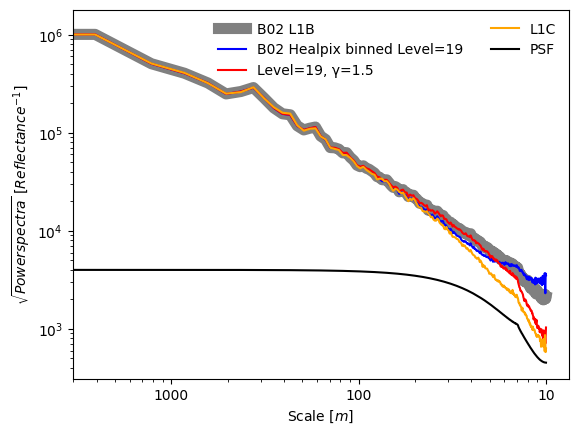

In [18]:
# --- Compute and compare power spectra from different image versions ---

# Compute radial power spectra (azimuthally averaged 2D FFT) for each image
f, r = radial_power_spectrum(data - np.mean(data))  # Original L1B image
f, r2 = radial_power_spectrum(res2 - np.mean(res2))  # PSF kernel image
f, r3 = radial_power_spectrum(res3 - np.mean(res3))  # HEALPix binned data
f, r4 = radial_power_spectrum(utm - np.mean(utm))  # Interpolation from L1C
f, ri = radial_power_spectrum(rim - np.mean(rim))  # Spline-regridded Healpix

# Normalize the spatial frequency axis for plotting (max = 10 meters scale)
xf = f / f.max() * 10

# Convert power spectra to amplitude spectra (square root)
ri = np.sqrt(ri)
r = np.sqrt(r)
r2 = np.sqrt(r2)
r3 = np.sqrt(r3)
r4 = np.sqrt(r4)

# Compute a scaling factor to match the L1C spectrum to the L1B reference
amp = np.sum(r4[1:20] * r[1:20]) / np.sum(r4[1:20] ** 2)
print(amp)  # Output scale correction factor

# Plot all spectra on a log-log plot
plt.plot(xf, r, color="grey", lw=8, label="B02 L1B")  # Reference
plt.plot(
    xf, r3, color="blue", label="B02 Healpix binned Level=%d" % level
)  # Binned HEALPix
plt.plot(xf, ri, color="red", label="Level=%d, γ=1.5" % level)  # HEALPix spline
plt.plot(xf, r4 * amp, color="orange", label="L1C")  # Interpolated from L1C (scaled)
plt.plot(xf, r2 * 1e5, color="black", label="PSF")  # Instrument PSF response

# Set plot to logarithmic scale
plt.xscale("log")
plt.yscale("log")

# Axis labels and tick marks
plt.xlabel(r"Scale [$m$]")
plt.ylabel(r"$\sqrt{Powerspectra}$ [$Reflectance^{-1}$]")
plt.xticks([1e-1, 1, 10], [1000, 100, 10])  # Custom tick labels for physical scales

# Add legend
plt.legend(frameon=False, ncol=2)

Text(0.5, 1.0, 'B02 Spline Upscale x5')

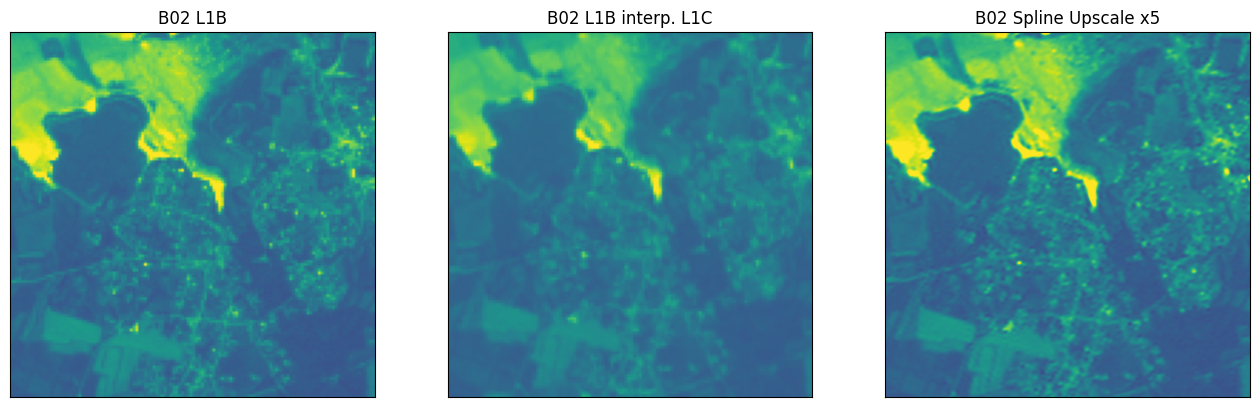

In [24]:
# --- Plot high-resolution zoom region from B02 band ---

plt.figure(figsize=(16, 6))  # Create a wide figure for side-by-side comparison

# Left: Original L1B subregion (128x128 pixels centered around the middle of the image)
plt.subplot(1, 3, 1)
plt.imshow(data[256 - dx : 256 + dx, 256 - dx : 256 + dx], vmin=200, vmax=500)
plt.xticks([])  # Hide x-axis ticks
plt.yticks([])  # Hide y-axis ticks
plt.title("B02 L1B")  # Title: original band from Level 1B

# Middle: Corresponding spline-upscaled version (5× resolution)
plt.subplot(1, 3, 2)
plt.imshow(utm[256 - dx : 256 + dx, 256 - dx : 256 + dx], vmin=200, vmax=500)
plt.xticks([])  # Hide x-axis ticks
plt.yticks([])  # Hide y-axis ticks
plt.title("B02 L1B interp. L1C")  # Title: high-resolution spline projection

# Right: Corresponding spline-upscaled version (5× resolution)
plt.subplot(1, 3, 3)
plt.imshow(rim2, vmin=200, vmax=500)
plt.xticks([])  # Hide x-axis ticks
plt.yticks([])  # Hide y-axis ticks
plt.title("B02 Spline Upscale x5")  # Title: high-resolution spline projection